# fbprophet 모듈 사용하기 - 시계열 예측

* 시계열(Time Series) 분석은 원 데이터의 안정성을 판정하고, 안정한 형태로 변환하고, 예측모델을 선정하고 검증하는 과정을 거친다.
* fbprophet 모듈을 사용하여, 위의 과정들을 간단히 이용하여 데이터 예측을 할 수 있다.

In [18]:
import folium
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import json
import googlemaps
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
import matplotlib.pyplot as plt
%matplotlib inline
import platform
import seaborn as sns
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family = 'AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system. sorry~~~')

import pandas_datareader.data as web
from fbprophet import Prophet
from datetime import datetime

In [19]:
pinkwink_web = pd.read_csv('../data/08. PinkWink Web Traffic.csv', encoding = 'utf-8', thousands=',', names=['date','hit'], index_col=0)
pinkwink_web = pinkwink_web[pinkwink_web['hit'].notnull()]
pinkwink_web.head()

,hit
date,
16. 7. 1.,766.0
16. 7. 2.,377.0
16. 7. 3.,427.0
16. 7. 4.,902.0
16. 7. 5.,850.0


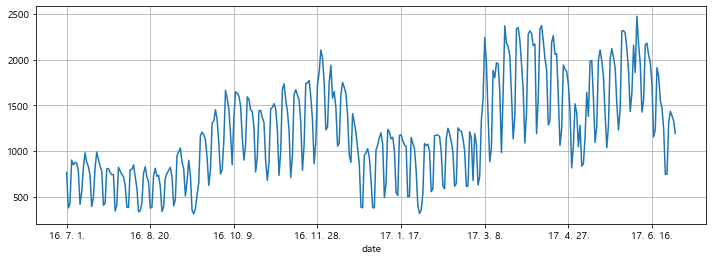

In [20]:
pinkwink_web['hit'].plot(figsize = (12,4), grid = True)

In [21]:
time = np.arange(0, len(pinkwink_web))
traffic = pinkwink_web['hit'].values
fx = np.linspace(0, time[-1], 1000)

## 모델의 적합성을 확인하기 위해, 참값과 비교하는 error 함수 생성

In [22]:
def error(f,x,y):
    return np.sqrt(np.mean((f(x)-y)**2))

## polyfit을 이용해 1,2,3,15차로 표현하여 참값과 비교하는 에러 계산하기

In [23]:
fp1 = np.polyfit(time, traffic, 1)
#1차함수의 매개변수로, time과 traffic을 넣어주고, 기울기를 가져온다. 
f1 = np.poly1d(fp1)

fp2 = np.polyfit(time, traffic, 2)
f2 = np.poly1d(fp2)
#2차함수의 매개변수로, time과 traffic을 넣어주고, 기울기를 가져온다. 

fp3 = np.polyfit(time, traffic, 3)
f3 = np.poly1d(fp3)
#3차함수의 매개변수로, time과 traffic을 넣어주고, 기울기를 가져온다. 

fp15 = np.polyfit(time, traffic, 15)
f15 = np.poly1d(fp15)
#15차함수의 매개변수로, time과 traffic을 넣어주고, 기울기를 가져온다. 

fp34 = np.polyfit(time, traffic, 34)
f34 = np.poly1d(fp34)
#34차함수의 매개변수로, time과 traffic을 넣어주고, 기울기를 가져온다. 

print(error(f1, time, traffic))
print(error(f2, time, traffic))
print(error(f3, time, traffic))
print(error(f15, time, traffic))
print(error(f34, time, traffic))


C:\Users\A\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2961: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


430.8597308110963
430.62841018946943
429.53280466762925
330.47773026564636
317.59347251477266


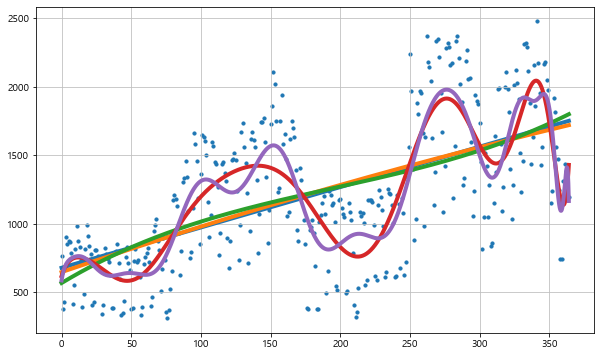

In [24]:
plt.figure(figsize=(10,6))
plt.scatter(time, traffic, s = 10)
#time 과 trffic에 한해서 산점도를 그린다. 

plt.plot(fx, f1(fx), lw = 4, label = 'f1')
plt.plot(fx, f2(fx), lw = 4, label = 'f2')
plt.plot(fx, f3(fx), lw = 4, label = 'f3')
plt.plot(fx, f15(fx), lw = 4, label = 'f15')
plt.plot(fx, f34(fx), lw = 4, label = 'f34')
# 15,34차 함수는 너무 최적화되어있어 과적합(over-fitting)일 수 있다.
# 어떤 모델을 선택할 지는 결국 분서가는 사람의 몫

plt.grid(True, linestyle = '-', color = '0.75')

# prophet 모듈을 이용한 forecast 예측

## -pinkwink_web 데이터에서, 날짜와 방문수를 가져오고, datetime type으로 형변환

In [35]:
df = pd.DataFrame({'ds':pinkwink_web.index, 'y':pinkwink_web['hit']})
df.reset_index(inplace = True)
df['ds'] = pd.to_datetime(df['ds'], format = "%y. %m. %d.")
del df['date']

### - Prophet 모듈 활용 

In [36]:
m = Prophet(yearly_seasonality=True)
# 주기성이 연단위(yearly_seasonality)로 있다고 알림
m.fit(df);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [37]:
future = m.make_future_dataframe(periods = 60)
# 데이터의 최종 일 로부터 이후 60일의 데이터를 예측하고자 데이터 프레임을 만들어준다. 
future.tail()

,ds
420,2017-08-25
421,2017-08-26
422,2017-08-27
423,2017-08-28
424,2017-08-29


In [40]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
420,2017-08-25,912.761130,706.387157,1123.205684
421,2017-08-26,497.711704,287.212547,713.908955
422,2017-08-27,630.268176,430.253631,822.762152
423,2017-08-28,1182.888299,981.175450,1403.604975
424,2017-08-29,1218.800002,1026.685346,1421.395235


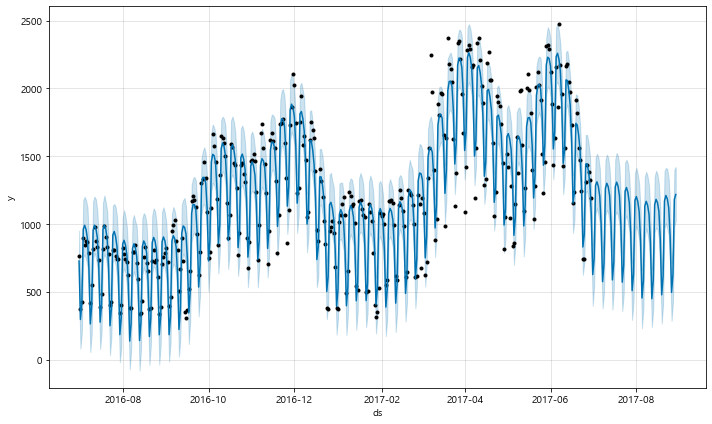

In [46]:
m.plot(forecast);

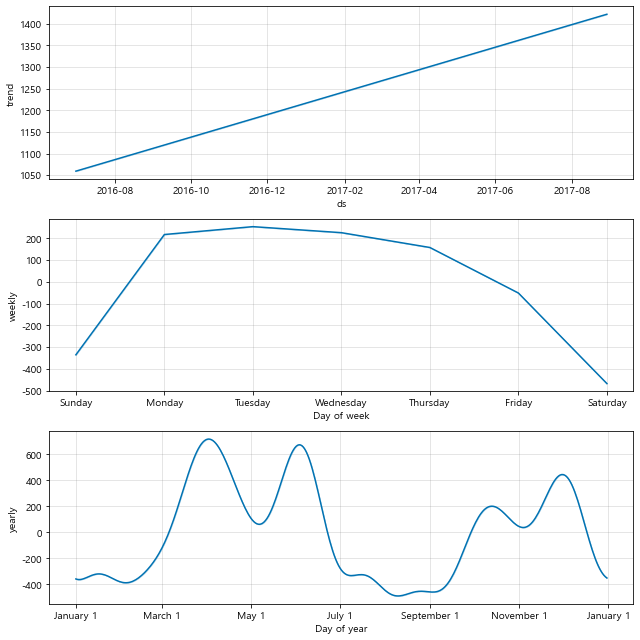

In [43]:
m.plot_components(forecast);
# 전체적인 경향은 직선, 꾸준히 방문자가 늘어난다는 것이며,
# 요일별, 월별로도 데이터들의 성향을 알수 있다.

# Seasonal 시계열 분석으로 주식 데이터 분석하기

* pandas 는 구글이 제공하는  주가 정보를 받아올 수 있는 기능이 있다. DataReader 함수로 종목 코드만 알면 한국 kospi도 얻어 올 수 있다.

In [49]:
from pandas_datareader import data

# 기아 주식 가져와보기(코스피)

In [72]:
start = datetime(2003,1,1)
end = datetime(2017,6,30)

df = data.get_data_yahoo("^KS11", start, end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2003-01-02,637.099976,623.750000,633.030029,635.169983,742800.0,635.169983
2003-01-03,662.400024,649.619995,651.590027,661.099976,1005800.0,661.099976
2003-01-06,667.710022,657.609985,665.099976,666.710022,721800.0,666.710022
2003-01-07,679.299988,652.140015,679.000000,652.200012,690200.0,652.200012
2003-01-08,660.390015,650.929993,655.969971,651.719971,604800.0,651.719971


# 삼성 주식 가져와보기

In [92]:
start_date = datetime(2009,7,1)
end_date = datetime(2019,12,31)

SAM = data.get_data_yahoo('005930.KS', start_date, end_date)
SAM_trunc = SAM[:'2017-06-30']
SAM.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-23,56400.0,55100.0,56100.0,55500.0,9839252.0,55500.0
2019-12-24,55700.0,54800.0,55600.0,55000.0,11868463.0,55000.0
2019-12-26,55400.0,54400.0,54700.0,55400.0,9645034.0,55400.0
2019-12-27,56900.0,55500.0,55700.0,56500.0,12313056.0,56500.0
2019-12-30,56600.0,55700.0,56200.0,55800.0,8356767.0,55800.0


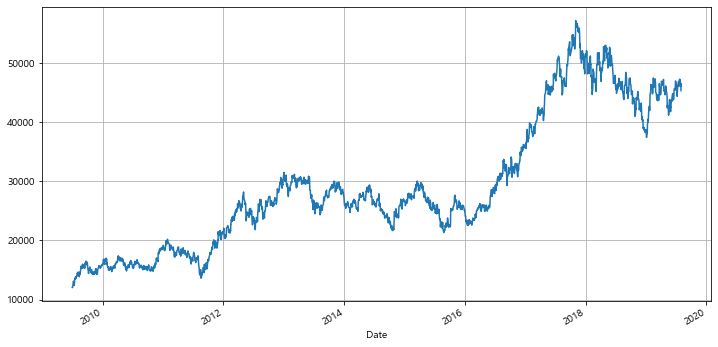

In [57]:
SAM['Close'].plot(figsize = (12,6), grid = True)

# 카카오 주식 가져와보기

In [56]:
start_date = datetime(2009,1,1)
end_date = datetime(2019,7,31)

KAKAO = data.get_data_yahoo('035720.KS', start_date, end_date)
KAKAO_trunc = KAKAO[:'2017-12-31']
KAKAO.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-01-02,32150.0,30000.0,31800.0,30000.0,276419.0,28382.277344
2009-01-05,30900.0,29700.0,30350.0,29900.0,165820.0,28287.669922
2009-01-06,31150.0,29950.0,30100.0,30750.0,204631.0,29091.835938
2009-01-07,32450.0,30800.0,31150.0,32450.0,249212.0,30700.166016
2009-01-08,32250.0,31350.0,31750.0,31850.0,179786.0,30132.517578


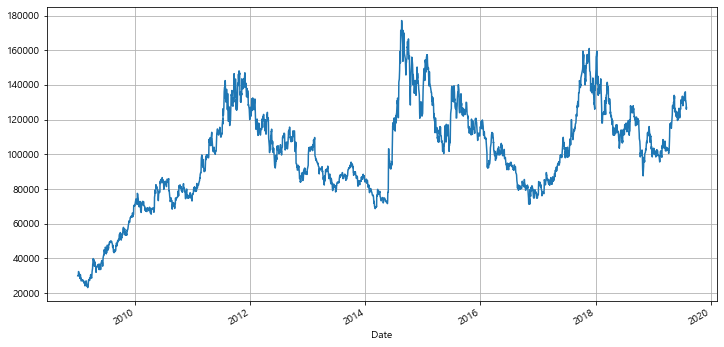

In [58]:
KAKAO['Close'].plot(figsize = (12,6), grid = True)

# 삼성 주식중, 일부를 추출하여 예측결과가 현실과 유사한지 확인

In [59]:
SAM_trunc

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-07-01,12120.0,11800.0,11880.0,12060.0,14641400.0,2.284350
2009-07-02,12200.0,12000.0,12200.0,12040.0,12677100.0,2.280561
2009-07-03,12040.0,11880.0,11900.0,12020.0,11348350.0,2.276772
2009-07-06,12820.0,12180.0,12200.0,12680.0,46675200.0,2.401787
2009-07-07,13120.0,12860.0,12980.0,13000.0,30934250.0,2.462400
...,...,...,...,...,...,...
2017-06-26,48360.0,47520.0,47520.0,48280.0,8552800.0,12258.283203
2017-06-27,48400.0,47900.0,48220.0,48300.0,9616750.0,12263.361328
2017-06-28,48000.0,47560.0,47600.0,47700.0,9572500.0,12111.021484


In [65]:
df = pd.DataFrame({'ds':SAM_trunc.index, 'y':SAM_trunc['Close']})
df.reset_index(inplace = True)
del df['Date']
df.head()

,ds,y
0,2009-07-01,12060.0
1,2009-07-02,12040.0
2,2009-07-03,12020.0
3,2009-07-06,12680.0
4,2009-07-07,13000.0


In [66]:
m = Prophet(daily_seasonality=True)
m.fit(df)

future = m.make_future_dataframe(periods = 365)
#일년의 기간을 예측해본다. 
future.tail()

,ds
2345,2018-06-26
2346,2018-06-27
2347,2018-06-28
2348,2018-06-29
2349,2018-06-30


In [67]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2345,2018-06-26,56578.538149,52051.991437,61501.885230
2346,2018-06-27,56533.518523,52163.551126,60996.628719
2347,2018-06-28,56520.979314,51977.509885,61539.456810
2348,2018-06-29,56418.568132,51839.841233,61411.474370
2349,2018-06-30,55996.682434,51229.575265,60720.818419


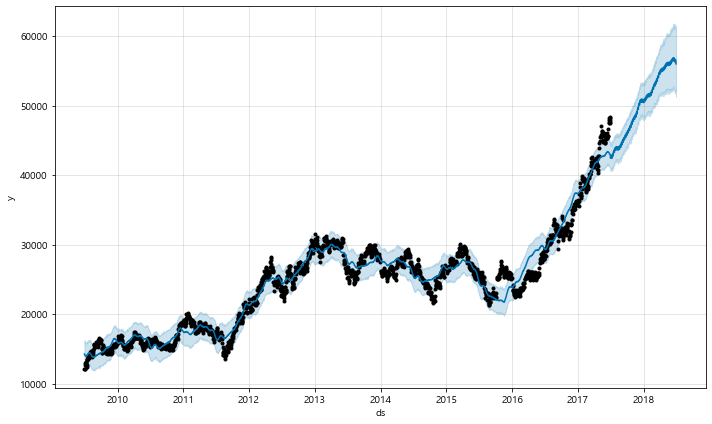

In [73]:
m.plot(forecast);
# 검은 saccter 가 실제 데이터를 의미하고, 파란 줄 라인이 예측 라인이다>

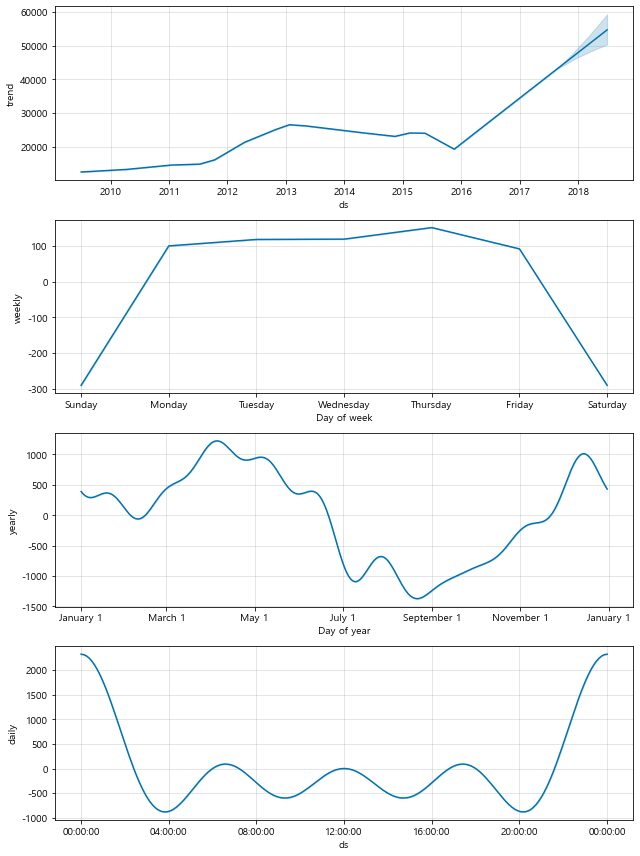

In [75]:
m.plot_components(forecast);

# 삼성 주가 예측 -> 기간이 짧으면 더욱 잘 예측할 것인가?

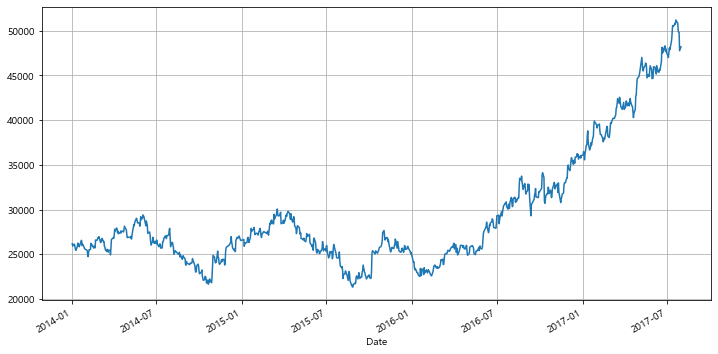

In [76]:
start_date = datetime(2014,1,1)
end_date = datetime(2017,7,31)

SAM = data.get_data_yahoo('005930.KS', start_date, end_date)
SAM_trunc = SAM[:'2017-07-31']

SAM['Close'].plot(figsize=(12,6), grid = True)



In [77]:
df = pd.DataFrame({'ds':SAM_trunc.index, 'y':SAM_trunc['Close']})
df.reset_index(inplace = True)
del df['Date']
m = Prophet(daily_seasonality=True)
m.fit(df);

In [78]:
future = m.make_future_dataframe(periods =61)
future.tail()

,ds
2041,2017-08-26
2042,2017-08-27
2043,2017-08-28
2044,2017-08-29
2045,2017-08-30


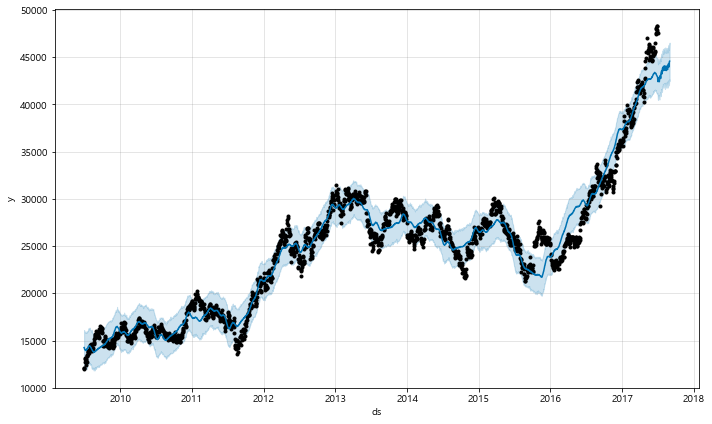

In [79]:
forecast = m.predict(future)
m.plot(forecast);

## 실제 주가 데이터와 예측모델 비교해보기

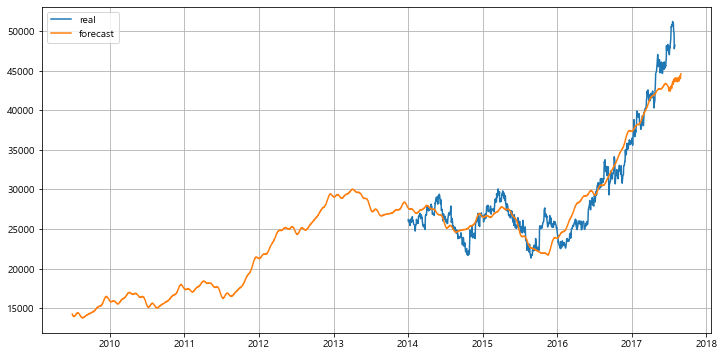

In [81]:
plt.figure(figsize=(12,6))
plt.plot(SAM.index, SAM['Close'],label= 'real')
plt.plot(forecast['ds'], forecast['yhat'], label = 'forecast')
plt.grid()
plt.legend()
plt.show()

# 4 Growth Model-prophet 예제 실습

In [83]:
df = pd.read_csv('../data/08. example_wp_R.csv')
df['y'] = np.log(df['y'])
df

,ds,y
0,2008-01-30,5.976351
1,2008-01-16,6.049733
2,2008-01-17,6.011267
3,2008-01-14,5.953243
4,2008-01-15,5.910797
...,...,...
2858,2015-12-11,7.834788
2859,2015-12-12,7.360104
2860,2015-12-13,7.479864
2861,2015-12-18,7.765145


In [84]:
df['cap'] = 8.5

In [88]:
m = Prophet(growth='logistic')
#주기성을 띄면서 점차 성장하는 모습의 데이터로, 모양새가 성장하면서 로그함수와 같기 때문에 옵션을 넣어줌
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


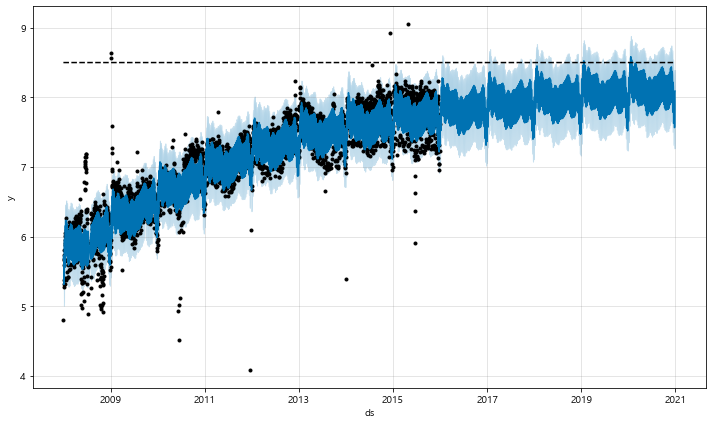

In [89]:
future = m.make_future_dataframe(periods = 1826)
future['cap'] = 8.5
#상한 지정
fcst = m.predict(future)
m.plot(fcst);

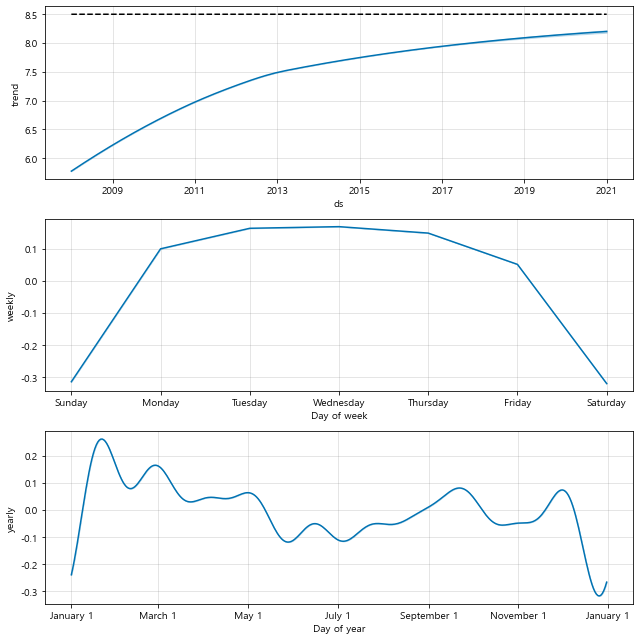

In [90]:
forecast = m.predict(future)
m.plot_components(forecast);

# prophet - 통계적 지식이 없어도 파라미터를 통해 모형을 조정할 수 있고, 
# 일반적인 경우 기본 값만 사용해도 높은 성능을 보여주는 
# 시계열 기반의 예측 라이브러리이다.
# https://facebook.github.io/prophet/  - 공식 홈페이지, 예시 등 논문 확인가능
# https://gorakgarak.tistory.com/1255 - 한글로 정리된 자료